In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.models import load_model
from sklearn.metrics import jaccard_score, f1_score
import glob

# -----------------------
# Utility functions
# -----------------------
def load_images_and_masks(image_dir, mask_dir, num_samples=None, target_size=(512, 512)):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    if num_samples:
        image_paths = image_paths[:num_samples]
        mask_paths = mask_paths[:num_samples]

    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = np.array(Image.open(img_path).convert('RGB').resize(target_size)).astype(np.float32) / 255.0
        mask = np.array(Image.open(mask_path).resize(target_size, Image.NEAREST))

        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

def compute_metrics(y_true, y_pred):
    # Flatten and remove batch dimension if present
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Map true mask values (0 and 255) to class indices (0 and 1)
    y_true_mapped = np.zeros_like(y_true)
    y_true_mapped[y_true == 0] = 0  # Background
    y_true_mapped[y_true == 255] = 1 # Residential
    # Assuming any other value in true mask would be Commercial (class 2),
    # although based on previous output only 0 and 255 are present.
    # If other values were present, more sophisticated mapping is needed.
    # For this specific case (0 and 255), we only map these two.

    # Filter out background for metric calculation as per original logic
    mask = y_true_mapped > 0
    y_true_filtered = y_true_mapped[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return 0, 0

    # Calculate metrics only on non-background classes
    # We need to calculate metrics across all classes that are present in the filtered true mask and corresponding predictions
    # Since we filtered for y_true_mapped > 0, the classes in y_true_filtered will be 1 (Residential) and potentially 2 (Commercial)
    # The classes in y_pred_filtered can be 0, 1, or 2.
    # To use average='macro', we need to ensure all relevant labels (1 and potentially 2) are present in y_true_filtered or y_pred_filtered.
    # However, since the model predicts 0, 1, 2, and true mask can be 0, 255, mapping 255 to 1 is correct.
    # If there's a commercial class in the true mask (e.g. value 128), it needs to be mapped to 2.
    # Based on the output of unique values in the true mask ([0, 255]), only classes 0 and 1 are relevant for the true mask.
    # The model predicts 0, 1, 2.
    # The jaccard_score and f1_score functions with average='macro' will calculate metrics for each unique label in the union of y_true and y_pred.
    # So, even if class 2 is not in y_true_filtered, if it's in y_pred_filtered, its metric will be calculated.

    # Let's use the original flattened arrays after mapping for metric calculation with relevant labels
    relevant_labels = np.unique(y_true_mapped)
    # Ensure predicted labels that are not in true labels but are predicted are also considered if average != None
    all_labels = np.unique(np.concatenate((y_true_mapped, y_pred)))
    # Filter out label 0 (Background) for macro average if we only want metrics on non-background.
    # However, average='macro' includes all unique labels in the union of y_true and y_pred.
    # If we want metrics only on Residential and Commercial, we should specify labels=[1, 2].
    # Let's check the unique values in the true mask array again to be sure.
    # Output from previous cell: Unique values in true mask: [  0 255]. This maps to [0, 1].
    # Output from previous cell: Unique values in predicted mask: [0 1 2].
    # So, the true classes are 0 and 1. The predicted classes are 0, 1, and 2.
    # For macro average on non-background, we should calculate for labels 1 and 2.

    iou = jaccard_score(y_true_mapped, y_pred, labels=[1, 2], average='macro', zero_division=0)
    dice = f1_score(y_true_mapped, y_pred, labels=[1, 2], average='macro', zero_division=0)


    return iou, dice


def classify_landuse(pred_mask_hw, probs_hwc=None):
    """Return 'Residential' or 'Commercial' based on majority area.
    - Uses predicted mask counts for classes 1 and 2.
    - If no foreground pixels and probabilities are provided, falls back to summed probabilities.
    - Ties default to 'Residential'.
    """
    pm = np.array(pred_mask_hw)
    res_count = int(np.sum(pm == 1))
    com_count = int(np.sum(pm == 2))

    if (res_count == 0 and com_count == 0) and (probs_hwc is not None) and (probs_hwc.ndim == 3) and (probs_hwc.shape[-1] >= 3):
        flat = probs_hwc.reshape(-1, probs_hwc.shape[-1]).sum(axis=0)
        res_prob_sum = float(flat[1]) if flat.shape[0] > 1 else 0.0
        com_prob_sum = float(flat[2]) if flat.shape[0] > 2 else 0.0
        return "Residential" if res_prob_sum >= com_prob_sum else "Commercial"

    # Majority vote with tie-break to Residential
    return "Residential" if res_count >= com_count else "Commercial"

# -----------------------
# Evaluation and visualization
# -----------------------
def evaluate_model_on_folder(model_path, image_dir, mask_dir, num_samples=5):
    print("📦 Loading trained model...")
    model = load_model(model_path)
    print("✅ Model loaded successfully!\n")

    print("📁 Loading sample images and masks...")
    images, true_masks = load_images_and_masks(image_dir, mask_dir, num_samples=num_samples)
    print(f"✅ Loaded {len(images)} image–mask pairs.\n")

    predictions = model.predict(images, verbose=1)

    # Convert prediction channels
    if predictions.shape[-1] > 1:
        pred_classes = np.argmax(predictions, axis=-1)
    else:
        pred_classes = (predictions > 0.5).astype(np.uint8).squeeze(-1)

    # Prepare masks
    if true_masks.shape[-1] > 1:
        true_masks = np.argmax(true_masks, axis=-1)
    else:
        true_masks = true_masks.squeeze().astype(np.uint8)

    colors = {
        0: [0, 0, 0],      # Background
        1: [255, 0, 0],    # Residential
        2: [0, 255, 0]     # Commercial
    }

    total_iou, total_dice = 0, 0

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    # Ensure axes is 2D for consistent indexing when num_samples == 1
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_samples):
        img = images[i]
        true_class = true_masks[i]
        pred_class = pred_classes[i]

        # Land-use label from predicted mask
        label = classify_landuse(pred_class)

        # Color maps
        true_colored = np.zeros((*true_class.shape, 3))
        pred_colored = np.zeros((*pred_class.shape, 3))
        for cls, color in colors.items():
            true_colored[true_class == cls] = np.array(color) / 255.0
            pred_colored[pred_class == cls] = np.array(color) / 255.0

        # Overlay
        overlay = np.clip(0.7 * img + 0.3 * pred_colored, 0, 1)

        # Metrics
        iou, dice = compute_metrics(true_class, pred_class)
        total_iou += iou
        total_dice += dice

        # Show visuals
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title(f"Predicted Mask — {label}\nIoU: {iou:.3f}, Dice: {dice:.3f}")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title("Overlay (Prediction on Image)")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

    avg_iou = total_iou / num_samples
    avg_dice = total_dice / num_samples

    print(f"\n📊 **Average IoU:** {avg_iou:.4f}")
    print(f"📊 **Average Dice Coefficient:** {avg_dice:.4f}\n")

    return avg_iou, avg_dice

Image path: c:\Users\USER\OneDrive\Desktop\realtyAI\cleaned\images\image_0855.png
Mask path: c:\Users\USER\OneDrive\Desktop\realtyAI\cleaned\masks\mask_0855.png
Unique values in true mask: [  0 255]
Counts of unique values in true mask: [247485  14659]
Unique values in predicted mask: [0 1 2]
Counts of unique values in predicted mask: [256263   5433    448]
Predicted land use: Residential
Unique values in predicted mask: [0 1 2]
Counts of unique values in predicted mask: [256263   5433    448]
Predicted land use: Residential


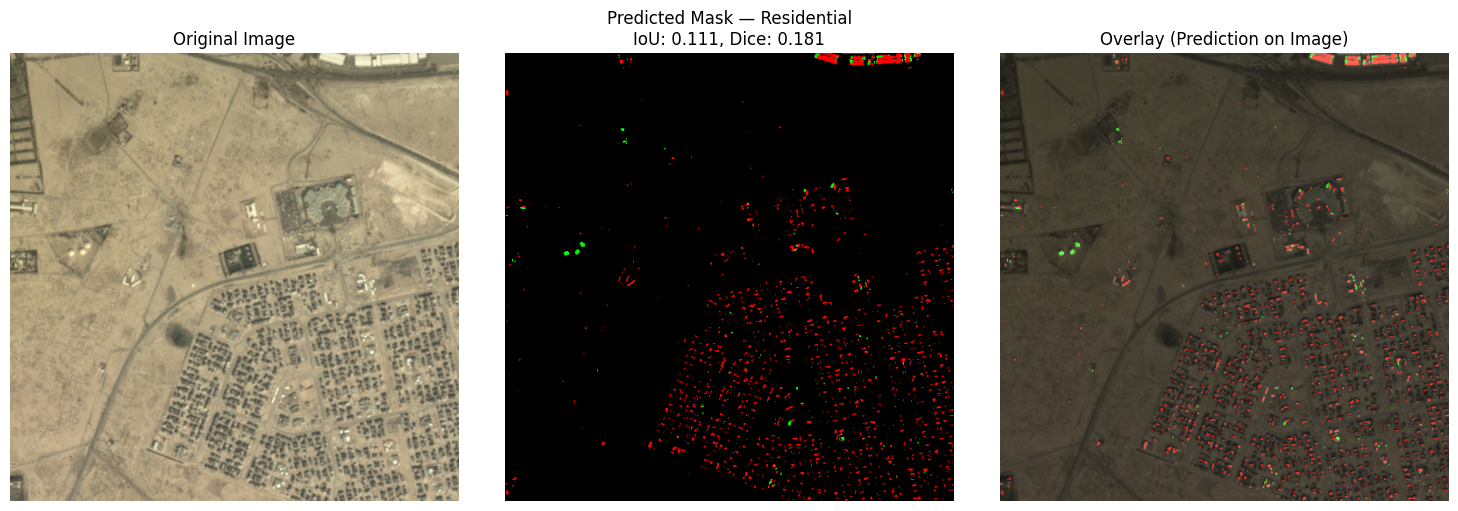

In [2]:
# Function to predict mask for a single image and show metrics

import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.utils import Sequence
from keras.models import Model
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from PIL import Image
import gc
import warnings
warnings.filterwarnings('ignore')

def predict_mask_and_show_metrics(model, image_path, mask_path, target_size=(512, 512)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Load and process true mask
    true_mask = Image.open(mask_path).convert('L')
    true_mask = true_mask.resize(target_size, Image.NEAREST)
    true_mask_array = np.array(true_mask, dtype=np.uint8)
    if len(true_mask_array.shape) == 2:
        true_mask_array = np.expand_dims(true_mask_array, axis=-1)
    if true_mask_array.shape[-1] > 1:
        true_mask_array = np.argmax(true_mask_array, axis=-1)
    else:
         true_mask_array = true_mask_array.squeeze().astype(np.uint8)

    # Print unique values in true mask
    unique_true_values, counts_true = np.unique(true_mask_array, return_counts=True)
    print(f"Unique values in true mask: {unique_true_values}")
    print(f"Counts of unique values in true mask: {counts_true}")


    prediction = model.predict(img_array, verbose=0)

    # Convert prediction channels
    if prediction.shape[-1] > 1:
        predicted_mask = np.argmax(prediction, axis=-1)
        # Classify land use using both mask counts and probability fallback
        label = classify_landuse(predicted_mask[0], prediction[0])
    else:
        predicted_mask = (prediction > 0.5).astype(np.uint8)
        # Binary fallback: treat any foreground as Residential; otherwise Commercial
        label = "Residential" if int(np.sum(predicted_mask)) > 0 else "Commercial"

    # Print unique values in predicted mask
    unique_pred_values, counts_pred = np.unique(predicted_mask, return_counts=True)
    print(f"Unique values in predicted mask: {unique_pred_values}")
    print(f"Counts of unique values in predicted mask: {counts_pred}")

    # Report land-use classification
    print(f"Predicted land use: {label}")

    # Calculate metrics
    iou, dice = compute_metrics(true_mask_array, predicted_mask)


    # Visualize the original image and the predicted mask
    original_image = Image.open(image_path).convert('RGB').resize((512, 512))
    original_image_array = np.array(original_image) / 255.0

    colors = {
        0: [0, 0, 0],      # Background
        1: [255, 0, 0],    # Residential
        2: [0, 255, 0]     # Commercial
    }

    predicted_colored = np.zeros((*predicted_mask.shape, 3))
    for cls, color in colors.items():
        predicted_colored[predicted_mask == cls] = np.array(color) / 255.0

    # Remove batch dimension before plotting
    predicted_colored = np.squeeze(predicted_colored, axis=0)

    # Overlay - Adjusted for a darker overlay
    overlay = np.clip(0.4 * original_image_array + 0.6 * predicted_colored, 0, 1)


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_colored)
    plt.title(f"Predicted Mask — {label}\nIoU: {iou:.3f}, Dice: {dice:.3f}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay (Prediction on Image)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Load the best model
model_path = 'best_model.h5'
model = load_model(model_path)

# Specify the path to a new image for prediction and its corresponding mask (relative to this notebook)
from pathlib import Path
project_root = Path.cwd()
image_dir = project_root / "cleaned" / "images"
mask_dir = project_root / "cleaned" / "masks"

# Prefer this image if it exists; otherwise we'll auto-pick the first valid pair
preferred_image = 'image_0855.png'
candidate_image = image_dir / preferred_image
candidate_mask = mask_dir / preferred_image.replace('image_', 'mask_')

if not (candidate_image.exists() and candidate_mask.exists()):
    # Auto-pick the first image/mask pair that exists
    candidate_image, candidate_mask = None, None
    for img_path in sorted(image_dir.glob('image_*.png')):
        msk_path = mask_dir / img_path.name.replace('image_', 'mask_')
        if msk_path.exists():
            candidate_image, candidate_mask = img_path, msk_path
            print(f"Using available pair: {img_path.name} ↔ {msk_path.name}")
            break
    if candidate_image is None:
        raise FileNotFoundError(f"No matching image/mask pairs found in {image_dir} and {mask_dir}")

new_image_path = str(candidate_image)
new_mask_path = str(candidate_mask)
print(f"Image path: {new_image_path}")
print(f"Mask path: {new_mask_path}")


# Perform prediction and show metrics
predict_mask_and_show_metrics(model, new_image_path, new_mask_path)

In [3]:
# Quick validation: confirm directories exist and list a few image↔mask pairs
from pathlib import Path
image_dir = Path.cwd() / "cleaned" / "images"
mask_dir = Path.cwd() / "cleaned" / "masks"

print("CWD:", Path.cwd())
print("Image dir:", image_dir, "exists:", image_dir.exists())
print("Mask dir:", mask_dir, "exists:", mask_dir.exists())

pairs = []
for img_path in sorted(image_dir.glob("image_*.png"))[:10]:
    msk_path = mask_dir / img_path.name.replace("image_", "mask_")
    pairs.append((img_path.name, msk_path.name, msk_path.exists()))

print("Sample pairs (mask_exists):")
for img_name, msk_name, ok in pairs:
    print(f" - {img_name} ↔ {msk_name} -> {ok}")

CWD: c:\Users\USER\OneDrive\Desktop\realtyAI
Image dir: c:\Users\USER\OneDrive\Desktop\realtyAI\cleaned\images exists: True
Mask dir: c:\Users\USER\OneDrive\Desktop\realtyAI\cleaned\masks exists: True
Sample pairs (mask_exists):
 - image_0000.png ↔ mask_0000.png -> True
 - image_0001.png ↔ mask_0001.png -> True
 - image_0002.png ↔ mask_0002.png -> True
 - image_0003.png ↔ mask_0003.png -> True
 - image_0004.png ↔ mask_0004.png -> True
 - image_0005.png ↔ mask_0005.png -> True
 - image_0006.png ↔ mask_0006.png -> True
 - image_0007.png ↔ mask_0007.png -> True
 - image_0008.png ↔ mask_0008.png -> True
 - image_0009.png ↔ mask_0009.png -> True
